**Imports**

In [2]:
import os
import glob
import pandas as pd
import SimpleITK as sitk
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**Data preparation**

In [3]:
DEBUG = True

In [4]:
def parse_info_file(info_file_path):
    info_dict = {}
    with open(info_file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            info_dict[key] = value if key == 'Group' else float(value) if '.' in value else int(value)
    return info_dict


def get_acdc_file_paths(data_paths):
    data_records = []
    for data_path, dataset_type in data_paths:
        # Get all the image and ground truth file paths
        image_pattern = os.path.join(data_path, 'patient*/patient*_frame??.nii.gz')
        gt_pattern = os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz')
        image_paths = glob.glob(image_pattern)
        gt_paths = glob.glob(gt_pattern)

        # Convert gt_paths to a dictionary for quick lookup
        gt_dict = {os.path.basename(gt_path).replace('_gt', ''): gt_path for gt_path in gt_paths}

        for image_path in image_paths:
            basename = os.path.basename(image_path)
            patient_number = basename.split('_')[0].replace('patient', '')
            frame_number = basename.split('_')[1].replace('frame', '').replace('.nii.gz', '')

            # Extracting the directory path to read the info.cfg
            patient_dir = os.path.dirname(image_path)
            info_file_path = os.path.join(patient_dir, 'Info.cfg')
            patient_info = parse_info_file(info_file_path)

            gt_path = gt_dict.get(basename, None)

            data_records.append({
                'patient_number': patient_number,
                'frame_number': frame_number,
                'image_path': image_path,
                'gt_path': gt_path,
                'dataset_type': dataset_type,
                **patient_info  # Add the info.cfg data to the record
            })

    # Create a DataFrame
    df = pd.DataFrame(data_records)

    return df

**Validate assumptions**

Before the dataframe is processed, we validate some assumptions that would make the process easier:

1. The rows are ordered such that for i = 0,2,4,...,288: rows i and i+1 always belong to patient_number i

2. The rows are ordered such that for i = 0,2,4,...,288: the frame number of row i always matches the ED number, and the frame number of row i+1 always matches the ES number, ignoring any leading zeros (ie: 01 = 1)

In [5]:
# Call the function with both paths and their dataset types
data_paths = [('../data/training', 'Training'), ('../data/testing', 'Testing')]
df_metadata = get_acdc_file_paths(data_paths)


def validate_dataframe(df):
    # Check for assumptions
    valid = True
    messages = []

    # Iterate over the DataFrame in steps of 2
    for i in range(0, len(df), 2):
        # Ensure there are enough rows remaining
        if i + 1 >= len(df):
            break

        row_current = df.iloc[i]
        row_next = df.iloc[i + 1]

        # Assumption 1: Rows i and i+1 belong to the same patient_number
        if row_current['patient_number'] != row_next['patient_number']:
            valid = False
            messages.append(f"Rows {i} and {i+1} do not belong to the same patient_number.")

        # Assumption 2: Frame number of row i matches ED,
        # and frame number of row i+1 matches ES (ignoring leading zeros)
        frame_number_current = int(row_current['frame_number'])
        frame_number_next = int(row_next['frame_number'])
        ed_number = row_current['ED']
        es_number = row_next['ES']

        if frame_number_current != ed_number:
            valid = False
            messages.append(f"Row {i} frame_number {frame_number_current} does not match ED {ed_number}.")

        if frame_number_next != es_number:
            valid = False
            messages.append(f"Row {i+1} frame_number {frame_number_next} does not match ES {es_number}.")

    return valid, messages


valid, messages = validate_dataframe(df_metadata)

if valid:
    print("The DataFrame meets all the specified assumptions.")
else:
    print("The DataFrame does not meet the specified assumptions:")
    for message in messages:
        print(message)

The DataFrame meets all the specified assumptions.


**Feature extraction methods**

In [6]:
def get_voxel_volume(image):
    spacing = image.GetSpacing()
    vol_voxel = spacing[0] * spacing[1] * spacing[2]
    return vol_voxel


def extract_features(image):
    vol_voxel = get_voxel_volume(image)

    # Convert the image to a NumPy array
    img_array = sitk.GetArrayFromImage(image)

    num_RV = np.sum(img_array == 1)
    num_MY = np.sum(img_array == 2)
    num_LV = np.sum(img_array == 3)

    vol_RV = num_RV * (vol_voxel / 1000)
    vol_MY = num_MY * (vol_voxel / 1000)
    vol_LV = num_LV * (vol_voxel / 1000)

    mass_MY = vol_MY * 1.055  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6461811/

    return vol_RV, vol_MY, vol_LV, mass_MY

**Features**

Volumes in ml of:

1. vRVED: right ventricle cavivity (RV) during End Dyastolic (ED)

2. vLVED: left ventricle cavivity (LV) during ED

3. vMYED: myocardium (MY) during ED

4. vRVES: RV during during End Systolic (ES)

5. vLVES: LV during ES

6. vMYES: MY during ES

In [7]:
df_metadata_copy = df_metadata.copy()

# Extract features
features_list = []
for path in df_metadata['gt_path']:
    segmentation_mask = sitk.ReadImage(path)
    if segmentation_mask is not None:
        features = extract_features(segmentation_mask)
        features_list.append(features)

# Convert the list of tuples to a NumPy array for better performance
features_list = np.array(features_list)

df_metadata_copy[['vRV', 'vMY', 'vLV', 'mMY']] = features_list

print(df_metadata_copy.head(5))

NiftiImageIO (0x10132d0): ../data/training/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/training/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/training/patient001/patient001_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/training/patient001/patient001_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/training/patient002/patient002_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/training/patient002/patient002_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/training/patient002/patient002_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/training/patient002/patient002_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/training/patient003/patient003_frame01_gt.nii.

  patient_number frame_number  \
0            001           01   
1            001           12   
2            002           01   
3            002           12   
4            003           01   

                                          image_path  \
0  ../data/training/patient001/patient001_frame01...   
1  ../data/training/patient001/patient001_frame12...   
2  ../data/training/patient002/patient002_frame01...   
3  ../data/training/patient002/patient002_frame12...   
4  ../data/training/patient003/patient003_frame01...   

                                             gt_path dataset_type  ED  ES  \
0  ../data/training/patient001/patient001_frame01...     Training   1  12   
1  ../data/training/patient001/patient001_frame12...     Training   1  12   
2  ../data/training/patient002/patient002_frame01...     Training   1  12   
3  ../data/training/patient002/patient002_frame12...     Training   1  12   
4  ../data/training/patient003/patient003_frame01...     Training   1  15   

 

NiftiImageIO (0x10132d0): ../data/testing/patient148/patient148_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/testing/patient148/patient148_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/testing/patient148/patient148_frame10_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/testing/patient148/patient148_frame10_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/testing/patient149/patient149_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/testing/patient149/patient149_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/testing/patient149/patient149_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data/testing/patient149/patient149_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data/testing/patient150/patient150_frame01_gt.nii.gz has un

In [8]:
unused_columns = ['image_path', 'gt_path', 'NbFrame', 'frame_number', 'ED', 'ES']
df_features = df_metadata_copy.drop(columns=unused_columns)

df_features_ED = df_features.groupby('patient_number').nth(0).reset_index()
df_features_ED.rename(columns={
    'vRV': 'vRVED',
    'vLV': 'vLVED',
    'vMY': 'vMYED',
    'mMY': 'mMYED'
}, inplace=True)

df_features_ES = df_features.groupby('patient_number').nth(1).reset_index()
df_features_ES.rename(columns={
    'vRV': 'vRVES',
    'vLV': 'vLVES',
    'vMY': 'vMYES',
    'mMY': 'mMYES'
}, inplace=True)

common_columns = ['Height', 'Weight', 'Group', 'dataset_type', 'index']
df_features_ES = df_features_ES.drop(columns=common_columns)

df_features = pd.merge(df_features_ED, df_features_ES, on='patient_number')

unused_columns = ['mMYES', 'vMYED', 'Height', 'Weight']
df_features = df_features.drop(columns=unused_columns)

df_features['efRV'] = (df_features['vRVED']-df_features['vRVES'])/df_features['vRVED']
df_features['efLV'] = (df_features['vLVED']-df_features['vLVES'])/df_features['vLVED']

df_training = df_features[df_features['dataset_type'] == 'Training']
df_training = df_training.drop(columns=['dataset_type', 'index', 'patient_number'])

df_testing = df_features[df_features['dataset_type'] == 'Testing']
dt_testing = df_testing.drop(columns=['dataset_type', 'index', 'patient_number'])

features = ['vRVED', 'vLVED', 'mMYED', 'vRVES', 'vMYES', 'vLVES', 'efRV', 'efLV']

print(df_training.head(5))

  Group       vRVED       vLVED       mMYED       vRVES       vMYES  \
0   DCM  139.721680  295.507812  173.291992   59.545898  195.068359   
1   DCM   94.432068  265.744400  169.257425   28.823090  192.565155   
2   DCM  192.333984  276.708984  202.397217  174.584961  201.074219   
3   DCM  106.264114  260.847092  177.717339   84.543991  174.957275   
4   DCM  170.463867  290.797119  212.469170   74.553223  232.261963   

        vLVES      efRV      efLV  
0  225.610352  0.573825  0.236533  
1  188.303375  0.694774  0.291412  
2  241.088867  0.092282  0.128728  
3  226.472473  0.204398  0.131781  
4  224.094727  0.562645  0.229378  


In [9]:
df_training = df_features[df_features['dataset_type'] == 'Training']
df_testing = df_features[df_features['dataset_type'] == 'Testing']

X_train = df_training[features]

X_test = df_testing[features]

y_train = df_training['Group']
y_test = df_testing['Group']

scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

# Creating and training the Random Forest model
rf_model = RandomForestClassifier(random_state=55)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [10]:
# Evaluating performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate recall and precision for each group/label separately and give the total f1-score
# Evaluating recall, precision, and F1-score for each group/label
report = classification_report(y_test, y_pred, output_dict=True)

# Printing the classification report
print("Classification Report:")
for label, metrics in report.items():
    if label in y_test.unique():
        print(f"Label: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")

# Printing the overall F1-score
print(f"\nOverall F1-score: {report['weighted avg']['f1-score']:.4f}")

Accuracy: 0.86
Classification Report:
Label: DCM
  Precision: 0.7273
  Recall: 0.8000
  F1-score: 0.7619
Label: HCM
  Precision: 1.0000
  Recall: 0.9000
  F1-score: 0.9474
Label: MINF
  Precision: 0.7778
  Recall: 0.7000
  F1-score: 0.7368
Label: NOR
  Precision: 0.9000
  Recall: 0.9000
  F1-score: 0.9000
Label: RV
  Precision: 0.9091
  Recall: 1.0000
  F1-score: 0.9524

Overall F1-score: 0.8597


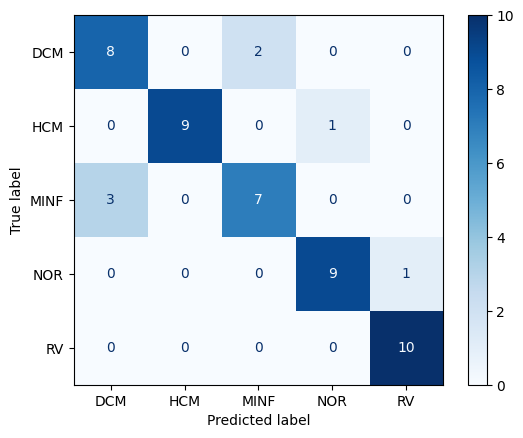

In [11]:
labels = sorted(set(y_test) | set(y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()

In [49]:
# Print pairs only when actual and predicted are different
for actual, predicted in zip(y_test, y_pred):
    if actual != predicted:
        print(f'Actual: {actual} | Predicted: {predicted}')

Actual: DCM | Predicted: MINF
Actual: NOR | Predicted: RV
Actual: HCM | Predicted: NOR
Actual: MINF | Predicted: DCM
Actual: MINF | Predicted: DCM
Actual: MINF | Predicted: DCM
Actual: DCM | Predicted: MINF


In [12]:
def get_seg_paths(data_path):
    paths = glob.glob(os.path.join(data_path, 'patient*_frame??_seg.nii.gz'))
    return paths


def extract_features_array(paths):
    x = []
    for path in paths:
        mask = sitk.ReadImage(path)
        features = extract_features(mask)
        x.append(features)
    return np.array(x)


seg_paths = get_seg_paths('../data_predictions/testing_predictions')

seg_features_array = extract_features_array(seg_paths)

NiftiImageIO (0x10132d0): ../data_predictions/testing_predictions/patient101_frame01_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data_predictions/testing_predictions/patient101_frame01_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data_predictions/testing_predictions/patient101_frame14_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data_predictions/testing_predictions/patient101_frame14_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data_predictions/testing_predictions/patient102_frame01_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x10132d0): ../data_predictions/testing_predictions/patient102_frame01_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data_predictions/testing_predictions/patient102_frame13_seg.nii.gz has unexpected scales in sform

NiftiImageIO (0x1085ae0): ../data_predictions/testing_predictions/patient102_frame13_seg.nii.gz has unex

In [18]:
unused_columns = ['image_path', 'gt_path', 'NbFrame', 'frame_number', 'ED', 'ES']

df_features_2 = df_metadata_copy.drop(columns=unused_columns)

df_temp = df_features_2[df_features_2['dataset_type'] == 'Testing']

print(df_temp.head(5))

print("_____________________")
print("_____________________")
print("_____________________")

print('vRV', 'vMY', 'vLV', 'mMY')

print(seg_features_array[0:5])

    patient_number dataset_type Group  Height  Weight         vRV         vMY  \
200            101      Testing   DCM   169.0    79.0  129.790590  127.583450   
201            101      Testing   DCM   169.0    79.0   70.063232  128.794685   
202            102      Testing   NOR   156.0    75.0  100.097656   73.120117   
203            102      Testing   NOR   156.0    75.0   49.804688   84.423828   
204            103      Testing  MINF   175.0   107.0   88.891602  173.754883   

            vLV         mMY  
200  222.598129  134.600540  
201  156.007104  135.878393  
202   79.443359   77.141724  
203   23.144531   89.067139  
204  178.173828  183.311401  
_____________________
_____________________
_____________________
vRV vMY vLV mMY
[[160.6636312  147.42079211 221.19847901 155.52893567]
 [141.41844837 148.12061694 168.03870826 156.26725087]
 [107.47070312 102.66113281  86.69433594 108.30749512]
 [ 97.04589844 109.52148438  40.38085938 115.54516602]
 [150.46386719 185.88867188 168

In [94]:
df_temp_2 = df_temp.copy()
df_temp_2['vRV'] = seg_features_array[:, 0]
df_temp_2['vMY'] = seg_features_array[:, 1]
df_temp_2['vLV'] = seg_features_array[:, 2]
df_temp_2['mMY'] = seg_features_array[:, 3]

df_temp_2_ED = df_temp_2.groupby('patient_number').nth(0).reset_index()
df_temp_2_ED.rename(columns={
    'vRV': 'vRVED',
    'vLV': 'vLVED',
    'vMY': 'vMYED',
    'mMY': 'mMYED'
}, inplace=True)

df_temp_2_ES = df_temp_2.groupby('patient_number').nth(1).reset_index()
df_temp_2_ES.rename(columns={
    'vRV': 'vRVES',
    'vLV': 'vLVES',
    'vMY': 'vMYES',
    'mMY': 'mMYES'
}, inplace=True)

common_columns = ['Height', 'Weight', 'Group', 'dataset_type', 'index']
df_temp_2_ES = df_temp_2_ES.drop(columns=common_columns)

df_features = pd.merge(df_temp_2_ED, df_temp_2_ES, on='patient_number')

unused_columns = ['mMYES', 'vMYED', 'Height', 'Weight']
df_features = df_features.drop(columns=unused_columns)

df_features['efRV'] = (df_features['vRVED']-df_features['vRVES'])/df_features['vRVED']
df_features['efLV'] = (df_features['vLVED']-df_features['vLVES'])/df_features['vLVED']

df_testing = df_features
dt_testing = df_testing.drop(columns=['dataset_type', 'index', 'patient_number'])

features = ['vRVED', 'vLVED', 'mMYED', 'vRVES', 'vMYES', 'vLVES', 'efRV', 'efLV']

In [96]:
print(df_testing.head(5))

   index patient_number dataset_type Group       vRVED       vLVED  \
0    200            101      Testing   DCM  160.663631  221.198479   
1    202            102      Testing   NOR  107.470703   86.694336   
2    204            103      Testing  MINF  150.463867  168.090820   
3    206            104      Testing   HCM  181.238457  147.742240   
4    208            105      Testing   HCM  157.365686  137.975906   

        mMYED       vRVES       vMYES       vLVES      efRV      efLV  
0  155.528936  141.418448  148.120617  168.038708  0.119786  0.240326  
1  108.307495   97.045898  109.521484   40.380859  0.097001  0.534216  
2  196.112549  121.289062  208.251953  121.069336  0.193899  0.279739  
3  151.490190  102.750392  173.088708   42.580570  0.433065  0.711791  
4  179.805499  132.401345  176.358856   55.481209  0.158639  0.597892  


Accuracy: 0.56
Classification Report:
Label: DCM
  Precision: 0.5882
  Recall: 1.0000
  F1-score: 0.7407
Label: HCM
  Precision: 1.0000
  Recall: 0.5000
  F1-score: 0.6667
Label: MINF
  Precision: 0.5714
  Recall: 0.4000
  F1-score: 0.4706
Label: NOR
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
Label: RV
  Precision: 0.4286
  Recall: 0.9000
  F1-score: 0.5806

Overall F1-score: 0.4917


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


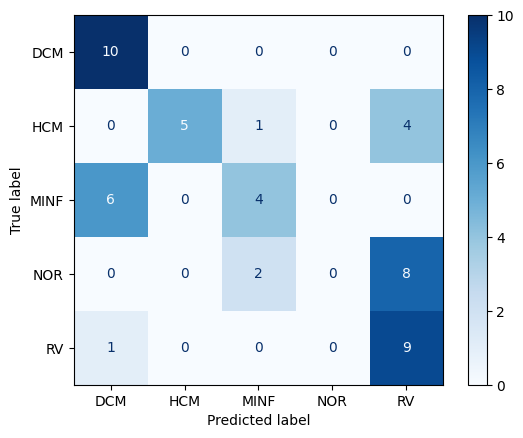

In [99]:
X_test = df_testing[features]

y_test = df_testing['Group']

y_pred = rf_model.predict(X_test)

labels = sorted(set(y_test) | set(y_pred))

# Evaluating performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate recall and precision for each group/label separately and give the total f1-score
# Evaluating recall, precision, and F1-score for each group/label
report = classification_report(y_test, y_pred, output_dict=True)

# Printing the classification report
print("Classification Report:")
for label, metrics in report.items():
    if label in y_test.unique():
        print(f"Label: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")

# Printing the overall F1-score
print(f"\nOverall F1-score: {report['weighted avg']['f1-score']:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()